# CS3440 - Lab 6

## Objectives
- Continue developing an understanding of data mining in _Python_
- Understand how to perform regression using _Scikit-learn_.
- Discuss about model under/overfitting.

## Suggested Reading
Jake VandePlas, *Python Data Science Handbook*, Chapter 5 (Machine Learning): <https://jakevdp.github.io/PythonDataScienceHandbook/>

## Instructions
This is a follow-on tutorial, with some _**TO DO**_ blocks containing specific activities. Please take your time at each block to understand what is being done, and feel free to tinker, explore and modify any block to check your understanding (if you break anything you can always ctrl-Z, or in the worst case download the original Notebook again).
*****

## Refresher: the `Scikit-Learn` API

The `Scikit-Learn` API is designed around the following guiding principles (read more [here](https://arxiv.org/abs/1309.0238)):

- Consistency: All objects share a common interface drawn from a limited set of methods, with consistent documentation.
- Inspection: All specified parameter values are exposed as public attributes.
- Limited object hierarchy: Only algorithms are represented by Python classes; datasets are represented in standard formats (`NumPy ndarrays`, `Pandas DataFrames`, `SciPy` sparse matrices) and parameter names use standard Python strings.
- Composition: Many machine learning tasks can be expressed as sequences of more fundamental algorithms, and `Scikit-Learn` makes use of this wherever possible.
- Sensible defaults: When models require user-specified parameters, the library defines an appropriate default value.

Every machine learning algorithm in `Scikit-Learn` is implemented via the _Estimator API_, which provides a consistent interface for a wide range of machine learning applications. The usual steps involved in using the API are as follows:

- Arrange the data into a features matrix and target vector.
- Choose a class of model by importing the appropriate estimator class from `Scikit-Learn`.
- Choose model hyperparameters by instantiating this class with desired values.
- Fit the model to your data by calling the `fit()` method of the model instance.
- Apply the Model to new data:
    - For supervised learning, often we predict labels for unknown data using the `predict()` method.
    - For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` methods.

***
## Simple linear regression

The first modelling task we will cover today is simple linear regression using ordinary least squares (OLS), to fit a simple linear regression of the form $y = \beta_0 + \beta_1x_1$. OLS models work under somewhat restrictive assumptions, but when those can be guaranteed linear modelling is a powerful and versatile modelling approach. A good overview of linear regression can be found, e.g., in Montgomery and Runger's [Applied Statistics and Probability for Engineers](https://www.wiley.com/en-us/Applied+Statistics+and+Probability+for+Engineers%2C+7th+Edition-p-9781119400363), and a shorter primer is available on [KDNuggets](https://www.kdnuggets.com/2016/06/brief-primer-linear-regression-part-1.html).

First, let's simulate some data:

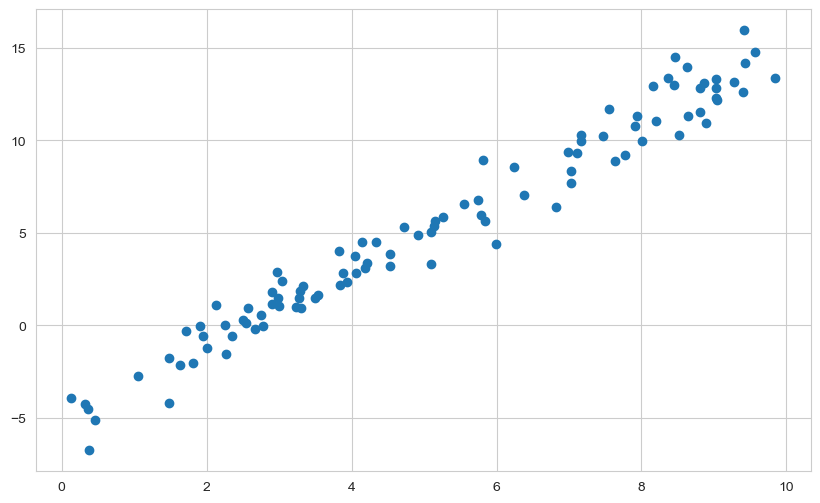

In [19]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Initialise a random number generator
rng = np.random.RandomState(2019)

# Generate 'Npts' randomly sampled values between 0 and 10
Npts = 100
x = 10 * rng.rand(Npts)

# simulate a linear relationship + some small magnitude Gaussian noise
y = -5 + 2 * x  + rng.randn(Npts)

# Plot
plt.figure(figsize = (10,6))
plt.scatter(x, y);

According the the sequence outlined earlier, the first step would be to put our data into the correct format for `Scikit-Learn`. For this case we need to get X and y as column vectors:

In [2]:
X = x[:, np.newaxis]
y = y[:, np.newaxis]

The next step is to select a class of model. In `Scikit-Learn` every class of model is represented by a Python class. In this case, since we want to compute a simple linear regression model, we can import the linear regression class.

Next we need to decide the model structure, which essentially defines a model instantiation from a general model family. Depending on the model class we might need to answer one or more questions like the following:
- Would we like to fit a coefficient for the offset (i.e., a y-intercept)?
- Would we like the model to be fit to normalised data?
- Would we like to preprocess our features to add model flexibility?
- What degree of regularization would we like to use in our model?
- How many model components would we like to use?

These are examples of the important choices that must be made once the model class is selected, but before the model is fit. These choices are often represented as _hyperparameters_, or parameters that must be set before the model is fit to data. In `Scikit-Learn`, hyperparameters are chosen by passing values at model instantiation, for instance:

In [3]:
from sklearn.linear_model import LinearRegression

# we want to fit y = a*x + b, not simply y = a*x.
# Initialise model structure:
model = LinearRegression(fit_intercept = True)
model

LinearRegression()

The next step is to fit the model to the data. This can be done with the `fit()` method of the model, which causes a number of model-dependent internal computations to take place. The results of these computations are stored in model-specific attributes that the user can explore. In `Scikit-Learn` all model parameters that were learned during the `fit()` process have trailing underscores. For instance, in the case of linear regression we'll have two parameters, `intercept_` and `coef_` (which for simple linear regression represents the _slope_):

In [4]:
model.fit(X, y)
print("Intercept:", model.intercept_)
print("Slope:", model.coef_)

Intercept: [-4.95384722]
Slope: [[1.99126814]]


This means that the best linear fit to this data is the line $y = -4.953 + 1.991x$, which is not too far from the actual linear relationship that generated the data ($y = -5 + 2x$). The variation is due to the Gaussian noise that we added to the points.

Now that we have a trained model, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set. In Scikit-Learn, this can be done using the `predict()` method. For the sake of this example, our "new data" will be a grid of x values, and we will ask what y values the model predicts:

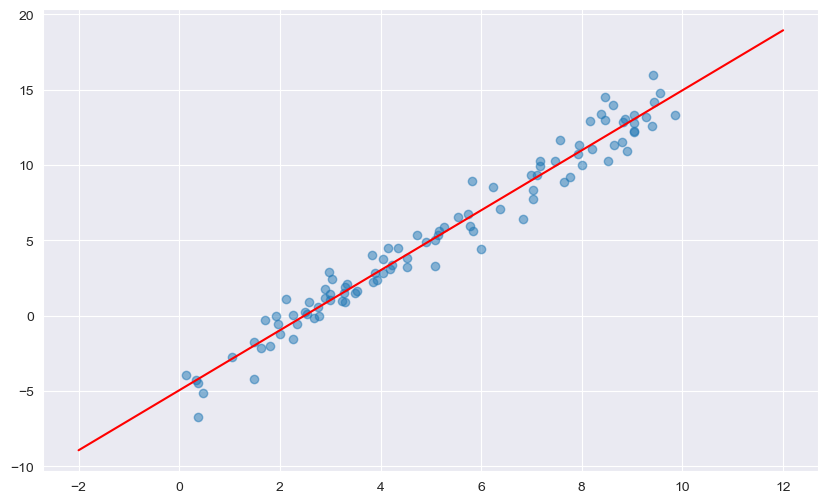

In [5]:
# Generate some new X values
Xnew = np.linspace(-2, 12)[:, np.newaxis]

# Get predictions of corresponding y values
yfit = model.predict(Xnew)

# Plot
plt.figure(figsize = (10,6))
plt.scatter(X, y, alpha = 0.5)
plt.plot(Xnew, yfit, 'r-')     # plot predictions as a line

Notice how the linear regression model captured the main relationship between the predictor `x` and the target variable `y`. This is a good sign, as it suggests that the model that we used had the right amount of complexity - it was neither too simple (which would have prevented it from picking up on the actual relationship between the variables) nor too complext (which would see it starting to model noise). This issue of model complexity is discussed next.

*****

## Model selection

One of the most important issues in practical data mining and machine learning is that of model selection and selection of hyperparameters. Of core importance is the following question: if our model is underperforming, how should we move forward? There are several possible answers:

- Use a more complicated/more flexible model
- Use a less complicated/less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counter-intuitive: sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results. Fundamentally, the question of "the best model" is about finding a sweet spot in the famous **bias-variance tradeoff**. Imagine two variables with a linear relationship (with a nonzero slope) and a model that essentially predicts y as a constant, shown below as the red line and as the formula $\hat{f}(x) = \beta_0$.

<center><img src="fig5-1.png" width="600"></center>

This model _underfits_ the data: its structure is not adequate (or has not enough flexibility) to adequately represent the data. This type of model is said to exhibit a large _bias_. For high-bias models, the performance of the model on the validation set is similar to the performance on the training set, which is commonly poor to begin with.

Now imagine another model that is capable of representing the relationship between y and x as a polynomial of arbitrarily high order:

<center><img src="fig5-2.png" width="600"></center>

This model has a completely different problem: it has too many degrees-of-freedom and is clearly modelling noise together with the actual relationship. Notice that it will certainly present a very low error when evaluated on the training data (blue dots), but any attempt to use it for predicting new data is likely to generate very large errors. This model is overfit to the training data, and is said to have high _variance_. For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

<center><img src="fig5-3.png" width="600"></center>

If we imagine that we have some ability to tune the model complexity, we would expect the training and validation errors to behave as illustrated in the following figure (image source: [Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)):

<center><img src="fig5-4.png" width="600"></center>

We can use cross-validation to compute the validation curve for a class of models. In the next example we will use a polynomial regression model, which is a generalisation of a simple linear model in which the degree of the polynomial is a tunable parameter. For example, a degree-1 polynomial fits a straight line to the data, $y = \beta_0 + \beta_1x$, and a degree-3 polynomial could have a functional form as, e.g., $y = \beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3$.

In `Scikit-Learn`,we can implement this with a simple linear regression combined with the polynomial preprocessor. We will use a _pipeline_ to string these operations together (more on this later).

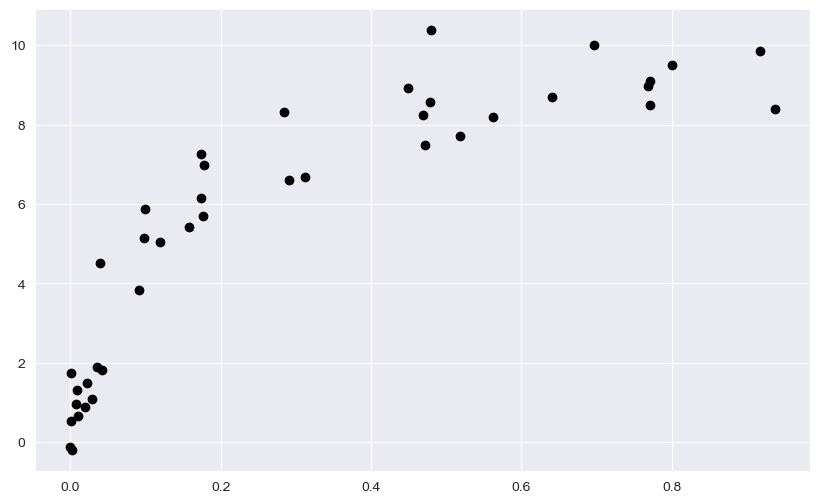

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Defining a function to generate linear regression to polynomials of arbitrary degree
def PolynomialRegression(degree = 2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

# Defining a function to generate some data
def make_data(N, err, rseed = 1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y


# Generate some data
X, y = make_data(N = 40, err = 1.0)
plt.figure(figsize=(10,6))
plt.scatter(X, y, color = 'k');

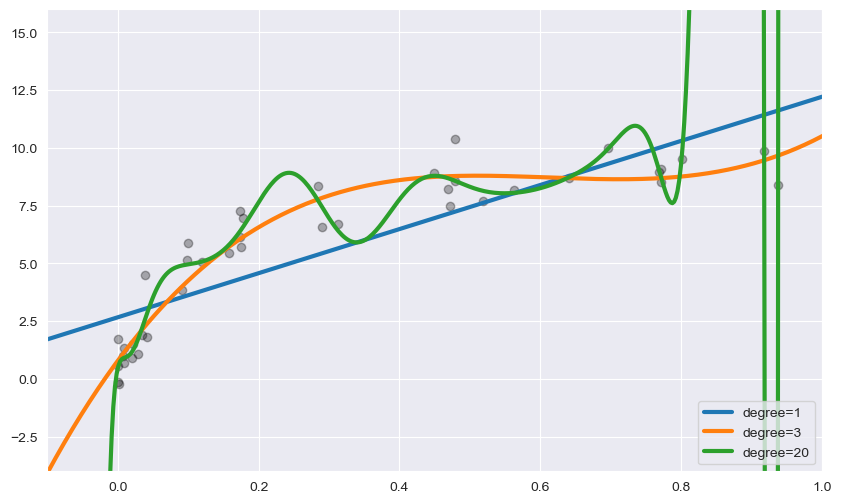

In [8]:
# Fit some models of different degrees
X_test = np.linspace(-0.1, 1.1, 500)[:, np.newaxis] # Test points

# Set up base plot with points
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', alpha = 0.3)

# Fit models of degree 1, 3 and 20
for degree in [1, 3, 20]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test, y_test,
             label = 'degree={0}'.format(degree),
             linewidth = 3)

plt.xlim(-0.1, 1.0)
plt.ylim(-4, 16)
plt.legend(loc = 'lower right');

In this case model complexity is controlled by the degree of the polynomial. But what degree of polynomial provides a suitable trade-off between bias and variance? In the visualisation above we can easily see that for very high complexities (e.g., degree = 20) the model becomes clearly unstable - it starts trying to "chase" every small pattern in the points, and loses sight of the "big picture" - the general patterns of the data.

One way to proceed to test the models (particularly when simple visualisations like the one above are not possible) is to visualise the validation curve for this particular data and model, which can be done using the `validation_curve` routine in `Scikit-Learn`. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training and validation scores across the range.

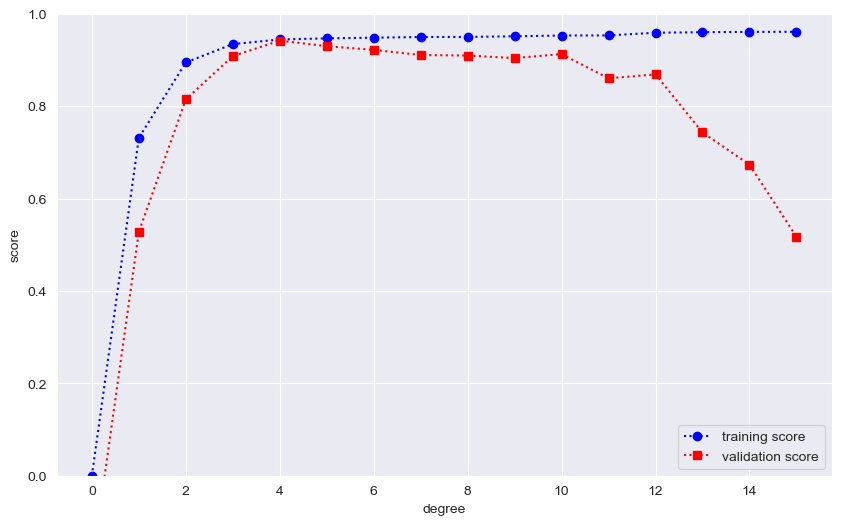

In [10]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 16)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name  = 'polynomialfeatures__degree',
                                          param_range = degree,
                                          cv = 10)

plt.figure(figsize=(10, 6))
plt.plot(degree, np.median(train_score, 1), ':ob',
         label = 'training score')
plt.plot(degree, np.median(val_score, 1), ':sr',
         label = 'validation score')
plt.legend(loc = 'best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score, and is monotonically improving with increased model complexity. The validation score reaches a maximum before dropping off as the model becomes overfit.

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a fourth-order polynomial; we can compute and display this fit over the original data:

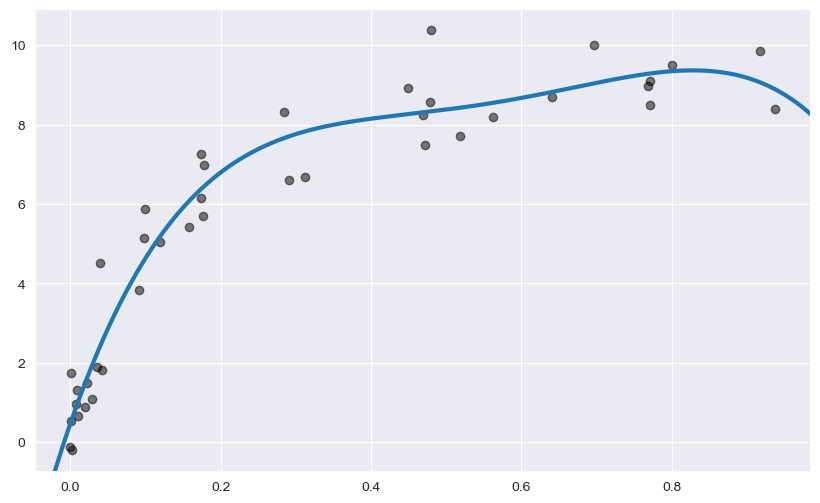

In [11]:
plt.figure(figsize = (10, 6))
plt.scatter(X, y, color = 'k', alpha = 0.5)
lim = plt.axis()
y_test = PolynomialRegression(4).fit(X, y).predict(X_test)
plt.plot(X_test, y_test, linewidth = 3)
plt.axis(lim);

which should illustrate quite well the importance of finding the right level of complexity for our regression models.

*****
## **TO DO**
(30 minutes)

So far we've seen how to do what is known as _simple linear regression_ - basically regression with a single predictor. In this block you'll try doing the next step: _multiple linear regression_. Don't worry - if you know how to do simple linear regression, multiple regression is just a feature matrix away.

Multiple linear regression models are generally of the form:

$y = \beta_0 + \sum_{k=1}^{n_{feat}}\beta_kx_k$

Notice that it is relatively straightforward to interpret each coefficient in multiple regression:
- The **Intercept** is the predicted mean value of the target variable (`y`) when all predictors are set to zero. It is very common that the intercept holds no physical interpretation - in many cases, all variables being zero does not make sense. In these cases the intercept can be seen as an "anchor" for the model.
- Each individual coefficient represents the expected change in the target variable if we had a unit change in the value of the variable associated to that coefficient, with all other variables being held constant.

For this exercise we'll use the Boston house prices dataset (See <https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset> for details):

In [26]:
import pandas as pd

# Load data
X = pd.read_csv("boston_data.csv")
y = pd.read_csv("boston_target.csv")

# Check the data
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [13]:
y.describe()

,0
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


Your activities are:
- Fit a linear regression model based on the data loaded above, using the features in matrix X to predict the median house price (y).
- Visualise the intercept and other coefficient values fitted by the model (these will be in the object `coef_` of the resulting model object, in the same order they appear in the feature matrix `X`.
- Based on the coefficients obtained, answer the following questions:
    - What is the expected difference in house value between two houses equal in all aspects, except that one bounds the Charles River and another doesn't (check the coefficient associated with variable `CHAS`)
    - For each unit increase in the per-capita crime rate of the town (`CRIM`), by how much does the expected house value change?



    Feature       Coef
0      CRIM  -0.108011
1        ZN   0.046420
2     INDUS   0.020559
3      CHAS   2.686734
4       NOX -17.766611
5        RM   3.809865
6       AGE   0.000692
7       DIS  -1.475567
8       RAD   0.306049
9       TAX  -0.012335
10  PTRATIO  -0.952747
11        B   0.009312
12    LSTAT  -0.524758
Expected difference in hourse prices are $2.686733819344951
Expected change in house value for each unit increase in per-capita crime rate: $-0.11
Expected change in house value for two unit decrease in per-capita crime rate: $-35.533


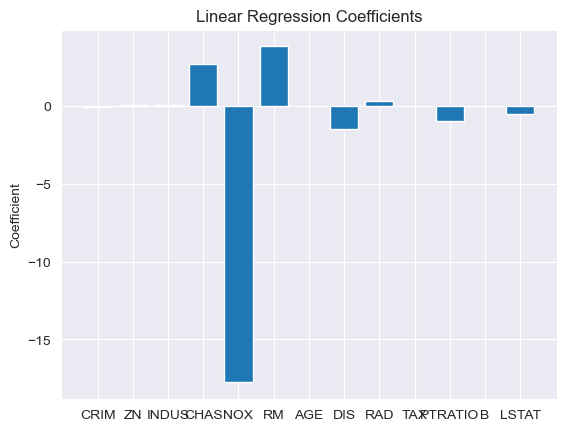

In [40]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)
coef_df = pd.DataFrame({'Feature': X.columns, 'Coef': model.coef_[0]})
print(coef_df)
chas_coef = coef_df.loc[coef_df['Feature'] == 'CHAS', 'Coef'].values[0]
print(f"Expected difference in hourse prices are ${chas_coef}")

crim_coef = coef_df.loc[coef_df['Feature'] == 'CRIM', 'Coef'].values[0]
print('Expected change in house value for each unit increase in per-capita crime rate: ${:,.2f}'.format(crim_coef))
crim_coef = coef_df.loc[coef_df['Feature'] == 'NOX', 'Coef'].values[0]
print('Expected change in house value for two unit decrease in per-capita crime rate: ${:,.3f}'.format(crim_coef*2))

plt.bar(coef_df['Feature'], coef_df['Coef'])
plt.ylabel('Coefficient')
plt.title('Linear Regression Coefficients')
plt.show()
